In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import ast
import scipy.io
import wfdb
from scipy.signal import butter, filtfilt
import tensorflow as tf


In [57]:
def apply_butterworth_filter(signal, sampling_rate=300, cutoff_freq=30, filter_order=6):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal, axis=-1)

def crop_or_pad_signal(signal, target_length=8000):
    current_length = signal.shape[-1]
    if current_length > target_length:
        return signal[..., :target_length]
    elif current_length < target_length:
        padding_size = target_length - current_length
        return np.pad(signal, ((0, 0), (0, padding_size)), mode='constant', constant_values=0)
    return signal

def normalize_signal(signal):
    signal_min, signal_max = np.min(signal), np.max(signal)
    if (signal_max - signal_min) == 0:
        return np.zeros_like(signal)
    return (signal - signal_min) / (signal_max - signal_min)

def read_ecg_signal(record_path):
    try:
        if record_path.endswith('.mat'):
            signal = scipy.io.loadmat(record_path)['val']
            if signal.shape[0] > signal.shape[1]:
                signal = signal.T
            return signal
        else:
            record = wfdb.rdrecord(record_path)
            try:
                lead_index = record.sig_name.index('II')
            except ValueError:
                lead_index = 0
            signal = record.p_signal.T[lead_index:lead_index+1, :]
            return signal
    except Exception as e:
        print(f"ERRO ao ler o arquivo {record_path}: {e}")
        return None

def build_test_file_bank(base_dir_project):
    print("Mapeando todos os arquivos de teste disponíveis...")
    test_file_bank = {'N': [], 'A': [], 'O': [], '~': []}
    ptbxl_scp_map = {'N': 'NORM', 'A': 'AFIB', 'O': ''}
    
    try:
        path = os.path.join(base_dir_project, "basededados", "training2017")
        labels_csv = os.path.join(path, "REFERENCE-original.csv")
        df = pd.read_csv(labels_csv, header=None, names=['record', 'label'])
        count = 0
        for _, row in df.iterrows():
            file_path = os.path.join(path, f"{row['record']}.mat")
            if os.path.exists(file_path) and row['label'] in test_file_bank:
                test_file_bank[row['label']].append({'path': file_path, 'label': row['label']})
                count += 1
        print(f"Mapeados {count} arquivos da 'basededados/training2017'.")
    except Exception as e:
        print(f"Falha ao carregar 'basededados/training2017': {e}")

    try:
        path = os.path.join(base_dir_project, "basededados2", "ruidos")
        count = 0
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith('.hea'):
                    file_path = os.path.join(root, file.replace('.hea', ''))
                    test_file_bank['~'].append({'path': file_path, 'label': '~'})
                    count += 1
        print(f"Mapeados {count} arquivos de ruído da 'basededados2/ruidos'.")
    except Exception as e:
        print(f"Falha ao carregar 'basededados2/ruidos': {e}")

    try:
        path = os.path.join(base_dir_project, "basededados2", "fa", "af-termination-challenge-database-1.0.0")
        count = 0
        for root, _, files in os.walk(path):
            for file in files:
                if file.endswith('.hea'):
                    file_path = os.path.join(root, file.replace('.hea', ''))
                    test_file_bank['A'].append({'path': file_path, 'label': 'A'})
                    count += 1
        print(f"Mapeados {count} arquivos da 'af-termination-challenge'.")
    except Exception as e:
        print(f"Falha ao carregar 'af-termination-challenge': {e}")
        
    try:
        path_records = os.path.join(base_dir_project, "basededados2", "fa", "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3")
        path_csv = os.path.join(path_records, "ptbxl_database.csv")
        df = pd.read_csv(path_csv, index_col='ecg_id')
        df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
        counts = {'N': 0, 'A': 0, 'O': 0}
        for _, row in df.iterrows():
            scp_codes = row['scp_codes'].keys()
            label = 'O'
            if ptbxl_scp_map['A'] in scp_codes: label = 'A'
            elif ptbxl_scp_map['N'] in scp_codes: label = 'N'
            file_path = os.path.join(path_records, row['filename_hr'])
            test_file_bank[label].append({'path': file_path, 'label': label})
            counts[label] += 1
        print(f"Mapeados {sum(counts.values())} arquivos do PTB-XL (N={counts['N']}, A={counts['A']}, O={counts['O']}).")
    except Exception as e:
        print(f"Falha ao carregar PTB-XL: {e}")

    print("\nBanco de Testes Criado.")
    for label, files in test_file_bank.items():
        print(f"  Classe '{label}': {len(files)} arquivos")
    return test_file_bank

def test_single_ecg(model, file_path, true_label, class_names):
    print(f"\nTestando Arquivo: {os.path.basename(file_path)}")
    print(f"Rótulo Verdadeiro: '{true_label}'")
    signal = read_ecg_signal(file_path)
    if signal is None: return
    signal_filtered = apply_butterworth_filter(signal)
    signal_resized = crop_or_pad_signal(signal_filtered)
    signal_normalized = normalize_signal(signal_resized)
    signal_for_model = np.expand_dims(signal_normalized, axis=-1)
    pred_proba = model.predict(signal_for_model, verbose=0)
    predicted_index = np.argmax(pred_proba)
    predicted_name = class_names[predicted_index]
    confidence = np.max(pred_proba) * 100
    print(f"Previsão do Modelo: '{predicted_name}' (Confiança: {confidence:.2f}%)")
    if predicted_name == true_label: print("Resultado: ACERTOU!")
    else: print(f"Resultado: ERROU! (Previu '{predicted_name}' mas era '{true_label}')")
    print("Probabilidades por classe:")
    for i, name in enumerate(class_names):
        print(f"  - {name}: {pred_proba[0][i]*100:.2f}%")
    plt.figure(figsize=(15, 4))
    plt.plot(signal_normalized.flatten())
    plt.title(f"Sinal de ECG (Pré-processado) - Rótulo Verdadeiro: {true_label}")
    plt.xlabel("Amostras")
    plt.ylabel("Amplitude Normalizada")
    plt.grid(True)
    plt.show()

ORDEM_DAS_CLASSES = ['A', 'N', 'O', '~']
NOME_DO_ARQUIVO_DO_MODELO = "modelo_kb2s_20251001_133257.keras" # SUBSTITUA PELO NOME CORRETO
CAMINHO_DO_MODELO = os.path.join("saved_models", NOME_DO_ARQUIVO_DO_MODELO)
DIRETORIO_DO_PROJETO = os.path.abspath("..")

try:
    print(f"Carregando modelo de: {CAMINHO_DO_MODELO}")
    loaded_model = tf.keras.models.load_model(CAMINHO_DO_MODELO)
    print("Modelo carregado com sucesso!\n")
    banco_de_testes = build_test_file_bank(DIRETORIO_DO_PROJETO)
except Exception as e:
    print(f"ERRO no setup: {e}")

print("\nSetup concluído. As ferramentas de teste estão prontas.")

Carregando modelo de: saved_models\modelo_kb2s_20251001_133257.keras
Modelo carregado com sucesso!

Mapeando todos os arquivos de teste disponíveis...
Mapeados 8528 arquivos da 'basededados/training2017'.
Mapeados 57 arquivos de ruído da 'basededados2/ruidos'.
Mapeados 80 arquivos da 'af-termination-challenge'.
Mapeados 21799 arquivos do PTB-XL (N=9477, A=1514, O=10808).

Banco de Testes Criado.
  Classe 'N': 14631 arquivos
  Classe 'A': 2365 arquivos
  Classe 'O': 13365 arquivos
  Classe '~': 103 arquivos

Setup concluído. As ferramentas de teste estão prontas.


--- MODO DE TESTE: TOTALMENTE ALEATÓRIO ---

Testando Arquivo: 20336_hr
Rótulo Verdadeiro: 'N'
Previsão do Modelo: 'N' (Confiança: 72.88%)
Resultado: ACERTOU!
Probabilidades por classe:
  - A: 0.01%
  - N: 72.88%
  - O: 27.11%
  - ~: 0.00%


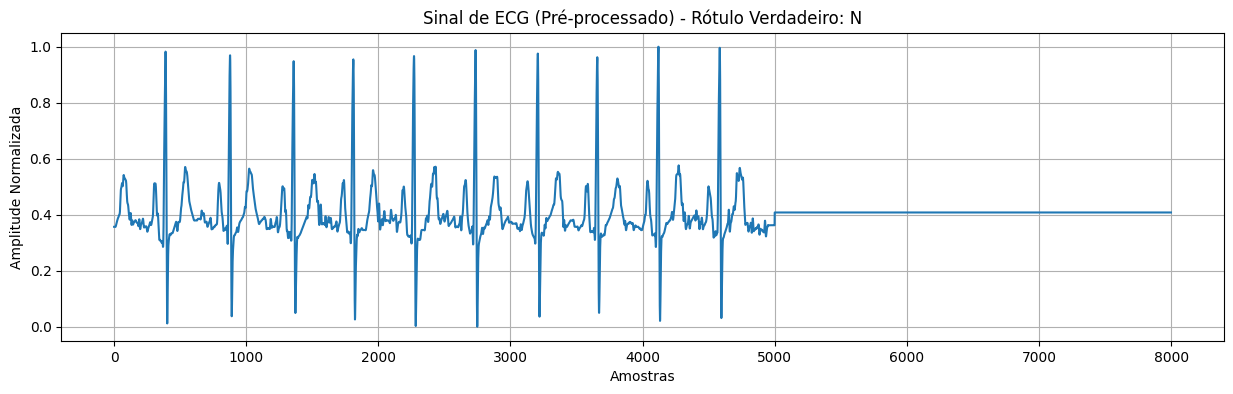

In [161]:
print("--- MODO DE TESTE: TOTALMENTE ALEATÓRIO ---")

if 'banco_de_testes' in locals() and 'loaded_model' in locals():
    pool_total = [item for sublist in banco_de_testes.values() for item in sublist]
    if pool_total:
        arquivo_selecionado = random.choice(pool_total)
        test_single_ecg(
            loaded_model, 
            arquivo_selecionado['path'], 
            arquivo_selecionado['label'], 
            ORDEM_DAS_CLASSES
        )
    else:
        print("ERRO: O banco de testes está vazio. Execute a Célula 1 primeiro.")
else:
    print("ERRO: Setup incompleto. Execute a Célula 1 primeiro.")

--- MODO DE TESTE: CLASSE ESPECÍFICA ('A') ---

Testando Arquivo: A03841.mat
Rótulo Verdadeiro: 'A'
Previsão do Modelo: 'N' (Confiança: 57.25%)
Resultado: ERROU! (Previu 'N' mas era 'A')
Probabilidades por classe:
  - A: 4.27%
  - N: 57.25%
  - O: 32.91%
  - ~: 5.57%


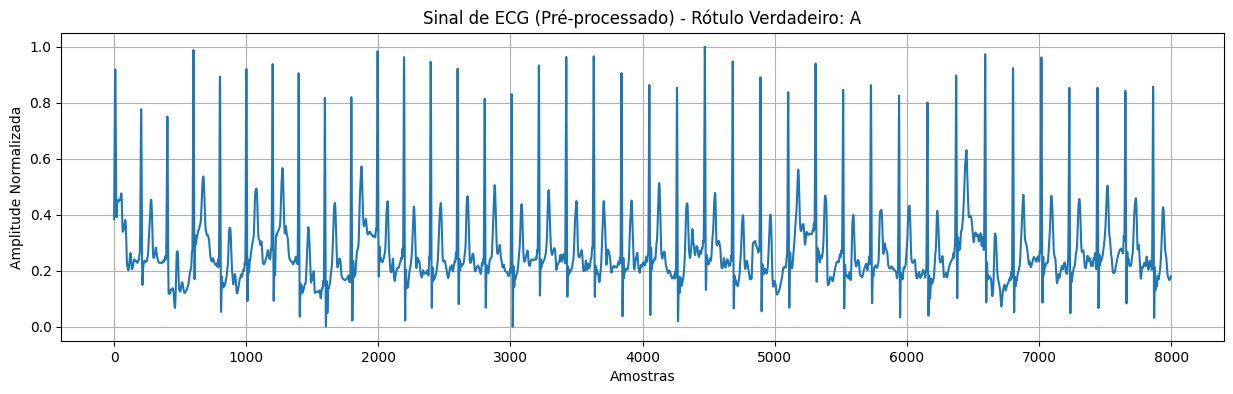

In [ ]:
CLASSE_PARA_TESTAR = 'A'
# Opções: 'A', 'N', 'O', '~'

print(f"--- MODO DE TESTE: CLASSE ESPECÍFICA ('{CLASSE_PARA_TESTAR}') ---")

if 'banco_de_testes' in locals() and 'loaded_model' in locals():
    if CLASSE_PARA_TESTAR in banco_de_testes and banco_de_testes[CLASSE_PARA_TESTAR]:
        arquivo_selecionado = random.choice(banco_de_testes[CLASSE_PARA_TESTAR])
        test_single_ecg(
            loaded_model, 
            arquivo_selecionado['path'], 
            arquivo_selecionado['label'], 
            ORDEM_DAS_CLASSES
        )
    else:
        print(f"ERRO: Classe '{CLASSE_PARA_TESTAR}' inválida ou sem arquivos no banco de testes.")
else:
    print("ERRO: Setup incompleto. Execute a Célula 1 primeiro.")